In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import analysis.fid as fid
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import h5py
import json

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

branched_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_branched_9classes_latent_d200/3/last_ckpt.pth")
label_guided_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_labelguided_9classes_latent_d200/3/last_ckpt.pth")

In [5]:
def import_classes_branch_points(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
        return d["classes"], \
            [(tuple(trip[0]), trip[1], trip[2]) for trip in d["branches"]]
    
classes, branch_defs = import_classes_branch_points(
    "/gstore/home/tsenga5/branched_diffusion/data/config/classes_branch_points/scrna_covid_flu/redset.json"
)

In [6]:
latent_space = True
latent_dim = 200

In [7]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
autoencoder_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d%d/" % latent_dim

In [8]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/scrna_covid_flu_sample_quality"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [9]:
dataset = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

[rank: 0] Global seed set to 0


INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae_d200/model.pt already downloaded                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [10]:
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)
t_limit = 1

In [11]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Import models

In [12]:
branched_model = model_util.load_model(
    scrna_ae.MultitaskResNet, branched_model_path
).to(DEVICE)

label_guided_model = model_util.load_model(
    scrna_ae.LabelGuidedResNet, label_guided_model_path
).to(DEVICE)

### Sample objects

In [13]:
# Sample digits of each class from branched model
branched_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    sample = generate.generate_continuous_branched_samples(
        branched_model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, num_samples=500, verbose=True
    )
    if latent_space:
        branched_samples[class_to_sample] = sample.cpu().numpy()
        sample = dataset.decode_batch(sample).cpu().numpy()
    branched_samples[class_to_sample] = sample

Sampling class: 0


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.89it/s]


Sampling class: 1


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.87it/s]


Sampling class: 2


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.84it/s]


Sampling class: 3


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.79it/s]


Sampling class: 4


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.80it/s]


Sampling class: 5


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.74it/s]


Sampling class: 7


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.75it/s]


Sampling class: 10


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.75it/s]


Sampling class: 12


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.73it/s]


In [14]:
# Sample digits of each class from label-guided model
label_guided_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    sample = generate.generate_continuous_label_guided_samples(
        label_guided_model, sde, class_to_sample, class_to_class_index_tensor,
        sampler="pc", t_limit=t_limit, num_samples=500, verbose=True
    )
    if latent_space:
        label_guided_samples[class_to_sample] = sample.cpu().numpy()
        sample = dataset.decode_batch(sample).cpu().numpy()
    label_guided_samples[class_to_sample] = sample

Sampling class: 0


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Sampling class: 1


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.33it/s]


Sampling class: 2


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Sampling class: 3


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Sampling class: 4


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Sampling class: 5


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Sampling class: 7


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Sampling class: 10


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.33it/s]


Sampling class: 12


100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


In [15]:
# Sample objects from the original dataset
true_samples = {}
if latent_space:
    true_latent_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset.cell_cluster == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=min(500, len(inds)), replace=False)
    sample = dataset.data[sample_inds]
    if latent_space:
        true_latent_samples[class_to_sample] = dataset.encode_batch(torch.tensor(sample, device=DEVICE)).cpu().numpy()
    true_samples[class_to_sample] = sample

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12


In [16]:
# # Rescale sampled values to match range of true values based on standard deviation
# def rescale_samples(samps, samp_class):
#     t = true_samples[samp_class]

#     s_z = (samps - np.mean(samps, axis=0, keepdims=True)) / np.std(samps, axis=0, keepdims=True)
#     s_trans = (s_z * np.std(t, axis=0, keepdims=True)) + np.mean(t, axis=0, keepdims=True)
    
#     return np.nan_to_num(s_trans)  # Convert NaNs to 0s

# if latent_space:
#     branched_samples_scaled, label_guided_samples_scaled = {}
#     for class_to_sample in classes:
#         branched_samples_scaled[class_to_sample] = rescale_samples(branched_samples[class_to_sample], class_to_sample)
#         label_guided_samples_scaled[class_to_sample] = rescale_samples(label_guided_samples[class_to_sample], class_to_sample)
# else:
#     branched_samples_scaled, label_guided_samples_scaled = branched_samples, label_guided_samples

### Compute FID

In [18]:
# Compute FID scores
fid_scores = {}
for class_to_sample in classes:
    print("FID of %d" % class_to_sample)
    branched = branched_samples[class_to_sample]
    label_guided = label_guided_samples[class_to_sample]
    true = true_samples[class_to_sample]
    branched_fid = fid.compute_fid(branched, true)
    label_guided_fid = fid.compute_fid(label_guided, true)
    fid_scores[class_to_sample] = (branched_fid, label_guided_fid)
    print("Branched FID: %.4f" % branched_fid)
    print("Label-guided FID: %.4f" % label_guided_fid)

FID of 0
Branched FID: 375.3394
Label-guided FID: 375.9273
FID of 1
Branched FID: 162.3776
Label-guided FID: 166.3055
FID of 2
Branched FID: 149.6286
Label-guided FID: 153.1675
FID of 3
Branched FID: 151.0971
Label-guided FID: 156.2666
FID of 4
Branched FID: 64.6149
Label-guided FID: 65.1992
FID of 5
Branched FID: 1604.8071
Label-guided FID: 1609.5925
FID of 7
Branched FID: 84.4859
Label-guided FID: 85.2968
FID of 10
Branched FID: 318.3276
Label-guided FID: 316.7784
FID of 12
Branched FID: 173.8220
Label-guided FID: 175.6205


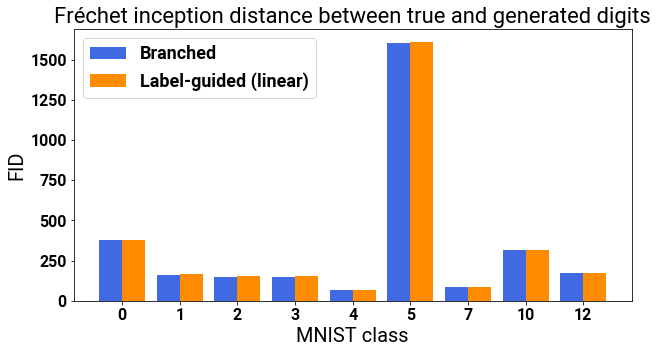

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.4
x = np.arange(len(fid_scores))
ax.bar(
    x, [fid_scores[c][0] for c in classes], bar_width, label="Branched", color="royalblue"
)
ax.bar(
    x + bar_width, [fid_scores[c][1] for c in classes], bar_width, label="Label-guided (linear)", color="darkorange"
)
ax.set_xticks(x + (bar_width / 2), labels=[("%d" % c) for c in classes])
ax.set_xlabel("MNIST class")
ax.set_ylabel("FID")
ax.set_title("Fréchet inception distance between true and generated digits")
ax.legend()
plt.show()
fig.savefig(
    os.path.join(out_path, "scrna_covid_flu_fid.svg"),
    format="svg"
)